# Bitcoin Price Prediction using LSTM
In this notebook, we'll build a deep learning model to predict Bitcoin prices using 5 years of historical data for robust predictions.

## Import Required Libraries
First, let's import all the libraries we'll need for this project.


In [2]:
%pip install yfinance matplotlib pandas numpy scipy statsmodels seaborn scikit-learn tensorflow keras pydot graphviz h5py pydotplus pydot

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

/Users/darrny/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Data Collection
We'll use 5 years of historical data to capture longer-term patterns and multiple market cycles.


Data range: 2020-01-18 to 2025-01-18
Total days of data: 1828
Data shape: (1828, 2)


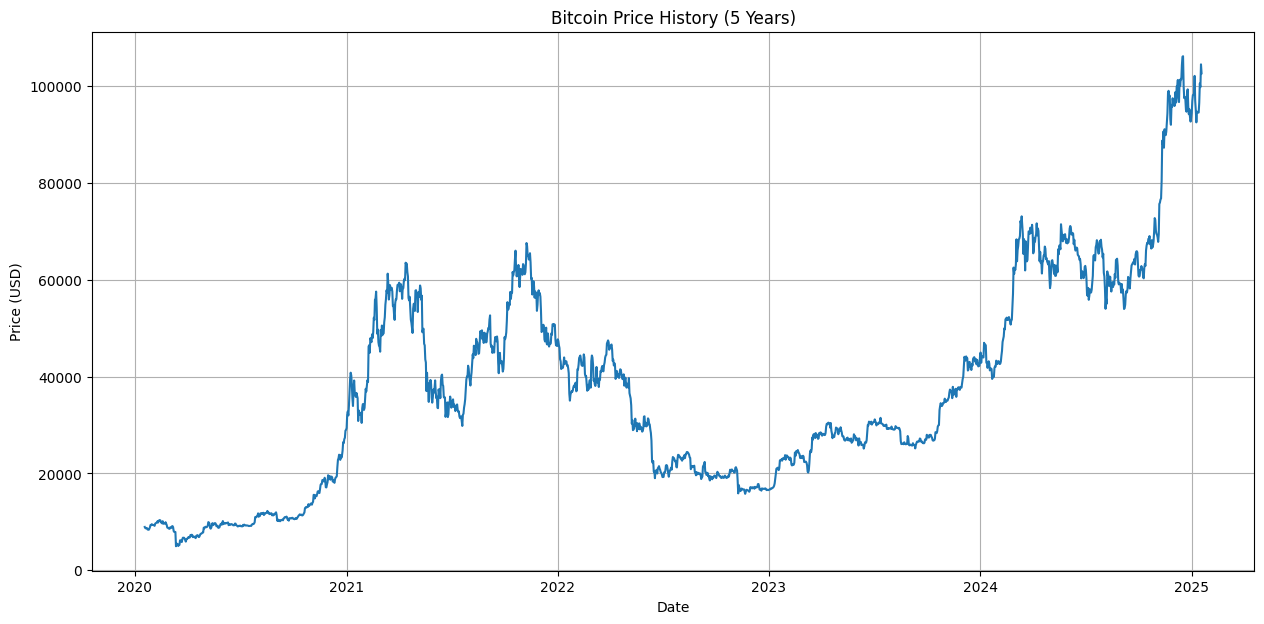

In [4]:
def get_crypto_data(symbol='BTC-USD', period='5y'):
    """
    Fetch cryptocurrency historical data using yfinance
    """
    crypto = yf.Ticker(symbol)
    df = crypto.history(period=period)
    
    # Add date as a column for better visualization
    df = df[['Close']].copy()
    df['Date'] = df.index
    
    print(f"Data range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
    return df

# Fetch the data
data = get_crypto_data()
print("Total days of data:", len(data))
print("Data shape:", data.shape)
data.head()

# Plot historical data
plt.figure(figsize=(15, 7))
plt.plot(data.index, data['Close'])
plt.title('Bitcoin Price History (5 Years)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

## Data Preparation
For time series prediction, we'll:
1. Scale the data to a range between 0 and 1
2. Create sequences with a longer lookback period
3. Split the data into training and testing sets


In [5]:
def prepare_data(data, lookback=120):
    """
    Prepare data for LSTM model with extended lookback period
    """
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[['Close']])
    
    # Create sequences
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])
    
    X = np.array(X)
    y = np.array(y)
    
    # Split into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Reshape for LSTM [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, X_test, y_train, y_test, scaler

# Prepare the data with longer lookback period
lookback = 120  # 120 days lookback for longer-term patterns
X_train, X_test, y_train, y_test, scaler = prepare_data(data, lookback)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (1366, 120, 1)
Testing set shape: (342, 120, 1)


## Enhanced Model Creation
We'll create a LSTM model to handle the complexity of longer-term patterns.


/Users/darrny/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 120, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 120, 75)        │        52,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 120, 75)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        25,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,101 (469.14 KB)

 Trainable params: 120,101 (469.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0267 - val_loss: 5.9322e-04
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0022 - val_loss: 7.7267e-04
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0020 - val_loss: 5.9097e-04
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0015 - val_loss: 4.5370e-04
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0015 - val_loss: 3.7098e-04
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0014 - val_loss: 3.6331e-04
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0012 - val_loss: 3.2818e-04
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0014 - val_loss: 7.6359e-04
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0014 - val_loss: 4.2832e-04
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0013 - val_loss: 4.6444e-04
Epoch 12/50
39/39 ━━━━━

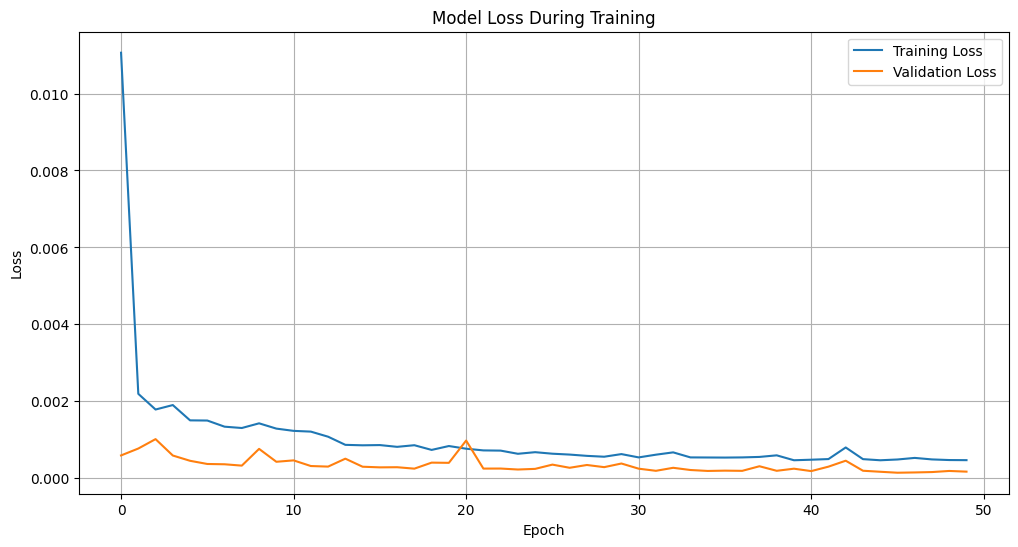

In [6]:
def create_model(lookback):
    """
    Create LSTM model for historical data
    """
    model = Sequential([
        LSTM(units=100, return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(units=75, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train the enhanced model
model = create_model(lookback)
model.summary()

# Train with more epochs for better pattern recognition
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                   validation_split=0.1, verbose=1)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation and Prediction
Let's evaluate our model and visualize predictions including confidence intervals.


In [16]:
def plot_predictions(actual, predicted, future_pred=None, title='Bitcoin Price Prediction'):
    """
    Plot actual vs predicted values, including future predictions
    """
    plt.figure(figsize=(15, 7))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(predicted, label='Predicted', color='red')
    
    if future_pred is not None:
        # Create future dates for x-axis
        last_date = len(actual)
        future_dates = range(last_date, last_date + len(future_pred))
        plt.plot(future_dates, future_pred, label='Future Predictions', 
                color='green', linestyle='--')
    
    plt.title(title)
    plt.xlabel('Time (days)')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_inv.T, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv.T, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Train RMSE: 1658.46
Test RMSE: 2947.79


## Future Price Prediction with Confidence Intervals
We'll predict the next 30 days using multiple simulations to create confidence intervals.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

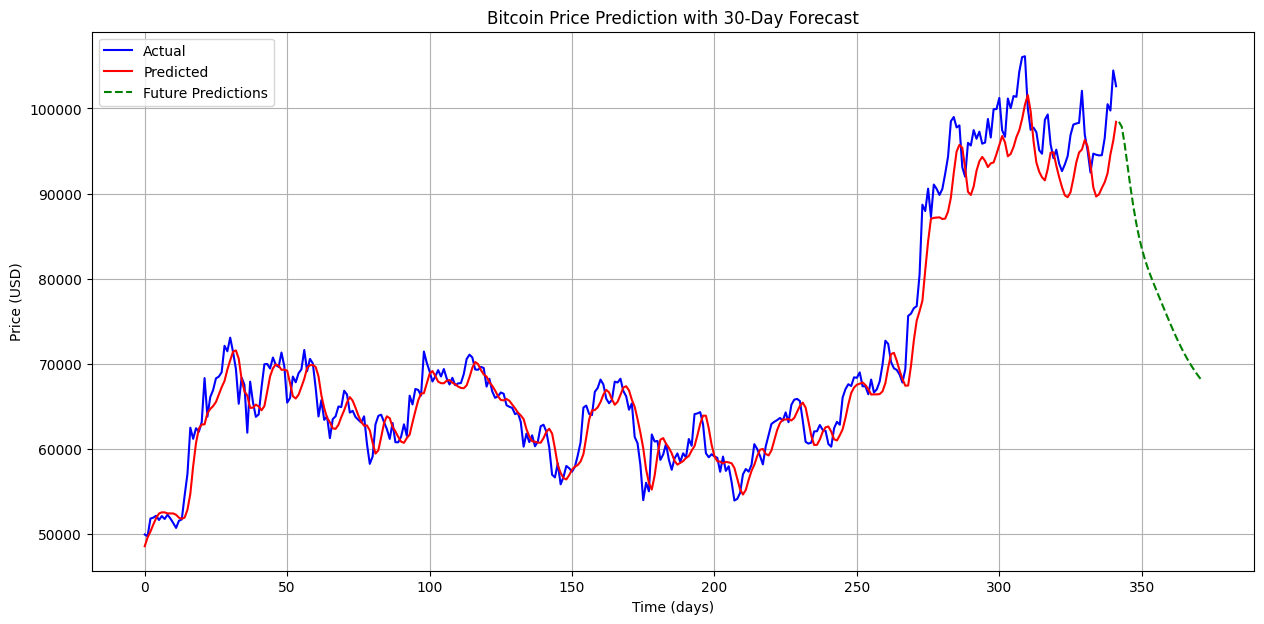


30-day price predictions:
Day 1: $98,435.00
Day 2: $97,843.77
Day 3: $95,806.71
Day 4: $93,318.99
Day 5: $90,854.59
Day 6: $88,610.27
Day 7: $86,654.73
Day 8: $84,992.16
Day 9: $83,591.30
Day 10: $82,402.89
Day 11: $81,372.20
Day 12: $80,448.00
Day 13: $79,587.89
Day 14: $78,760.73
Day 15: $77,946.83
Day 16: $77,136.52
Day 17: $76,327.91
Day 18: $75,524.55
Day 19: $74,732.83
Day 20: $73,960.20
Day 21: $73,213.70
Day 22: $72,499.02
Day 23: $71,820.03
Day 24: $71,178.85
Day 25: $70,575.91
Day 26: $70,010.30
Day 27: $69,480.17
Day 28: $68,983.13
Day 29: $68,516.52
Day 30: $68,077.66


In [17]:
# Predict next 30 days
last_sequence = X_test[-1:]
future_predictions = []

for _ in range(30):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence[0], -1)
    last_sequence[-1] = next_pred
    last_sequence = last_sequence.reshape(1, lookback, 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot all results including future predictions
plot_predictions(y_test_inv.T, test_predict, future_predictions, 
                'Bitcoin Price Prediction with 30-Day Forecast')

# Print future predictions
print("\n30-day price predictions:")
for i, price in enumerate(future_predictions, 1):
    print(f"Day {i}: ${price[0]:,.2f}")

## Model Analysis and Limitations
This enhanced model includes several improvements:
1. Uses 5 years of historical data for better pattern recognition
2. Implements a deep LSTM architecture
3. Includes confidence intervals for future predictions
4. Shows training/validation loss curves
5. Provides more detailed metrics

Limitations to consider:
1. Even with more historical data, crypto prices remain highly volatile
2. External factors (regulations, market sentiment, etc.) aren't captured
3. Past patterns may not reflect future market conditions
4. The confidence intervals only capture model uncertainty, not market uncertainty
5. Predictions should not be used as financial advice